# 1. Data Gathering

### Import Library

In [1]:
import os
import shutil
from sklearn.model_selection import train_test_split

### Assign Folder Paths

In [2]:
source_folder = "../dataset/CEDAR"
train_folder = "../CEDAR-dataset/train"
test_folder = "../CEDAR-dataset/test"

### Train and Test Data Splitting

In [3]:
def split_data(source_folder, train_folder, test_folder):
    if not os.path.exists(train_folder):
        os.makedirs(train_folder)
    if not os.path.exists(test_folder):
        os.makedirs(test_folder)

    signatures = [folder for folder in os.listdir(source_folder) if os.path.isdir(os.path.join(source_folder, folder))]

    paired_signatures = list(zip(signatures[::2], signatures[1::2]))

    train_signature, test_signature = train_test_split(paired_signatures, test_size=0.2, random_state=3)

    # print(train_signature)
    # print(test_signature)

    for signature in train_signature:
        for sig in signature:
            source_path = os.path.join(source_folder, sig)
            destination_path = os.path.join(train_folder, sig)
            shutil.copytree(source_path, destination_path)

    for signature in test_signature:
        for sig in signature:
            source_path = os.path.join(source_folder, sig)
            destination_path = os.path.join(test_folder, sig)
            shutil.copytree(source_path, destination_path)

In [4]:
# Only run if train and test data do not exist yet
# split_data(source_folder, train_folder, test_folder)

# 2. Data Pre-Processing

### Resizing

In [5]:
import cv2 as cv

In [6]:
def resize_images(folder_path, new_size=(224, 224)):
     signatures = [folder for folder in os.listdir(folder_path) if os.path.isdir(os.path.join(folder_path, folder))]
     for signature in signatures:
          signature_path = os.path.join(folder_path, signature)
          images = os.listdir(signature_path)
          for image in images:
               image_path = os.path.join(signature_path, image)
               img = cv.imread(image_path)
               resized_img = cv.resize(img, new_size)
               cv.imwrite(image_path, resized_img)

In [7]:
# Only run if train and test data are not 224x224 yet
# resize_images(train_folder)
# resize_images(test_folder)

### Shuffling

In [8]:
import random

In [9]:
def shuffle_data(folder_path):
    signatures = [folder for folder in os.listdir(folder_path) if os.path.isdir(os.path.join(folder_path, folder))]
    for signature in signatures:
        signature_path = os.path.join(folder_path, signature)
        images = os.listdir(signature_path)
        random.shuffle(images)
        for i, image in enumerate(images):
            os.rename(os.path.join(signature_path, image), os.path.join(signature_path, f"{i+1}.png"))

In [10]:
# Only run if train and test data are not renamed yet
# shuffle_data(train_folder)
# shuffle_data(test_folder)

### Formation of Feature Vectors

In [11]:
import numpy as np
from tensorflow.keras.preprocessing.image import img_to_array

In [12]:
def process_data(folder_path, target_size=(224, 224)):
    data = []
    labels = []

    signatures = [folder for folder in os.listdir(folder_path) if os.path.isdir(os.path.join(folder_path, folder))]
    for signature in signatures:
        signature_path = os.path.join(folder_path, signature)
        images = os.listdir(signature_path)
        for image in images:
            image_path = os.path.join(signature_path, image)
            img = cv.imread(image_path)
            
            gray_img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
            img_array = img_to_array(gray_img)

            data.append(img_array)
            if("forg" in signature):
                labels.append(np.array(0))
            else:
                labels.append(np.array(1))

    data = np.array(data)/255.0
    labels = np.array(labels)

    return data, labels

    

In [13]:
# train_data, train_labels = process_data(train_folder)
# test_data, test_labels = process_data(test_folder)

In [14]:
# print(train_labels.shape)
# print(train_data.shape)
# print(test_labels.shape)
# print(test_data.shape)

# 3. Feature Extraction

In [15]:
from tensorflow import keras
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras import optimizers
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt

In [16]:
size = 224

In [17]:
vgg16_train_path = "../CEDAR-features/vgg16_features_train.npy"
vgg16_test_path = "../CEDAR-features/vgg16_features_test.npy"

In [18]:
def extract_feature():
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=(size, size, 3))

    model = keras.Sequential()
    model.add(base_model)
    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(loss='binary_crossentropy', optimizer=optimizers.Adam(lr=1e-4), metrics=['accuracy'])

    model.summary()

    train_features = base_model.predict(preprocess_input(train_data))
    test_features = base_model.predict(preprocess_input(test_data))

    np.save(vgg16_train_path, train_features)
    np.save(vgg16_test_path, test_features)

    # progess = model.fit(train_data, train_labels, batch_size=64, epochs=6, callbacks=early_stop, validation_split=0.3)

In [19]:
# extract_feature()

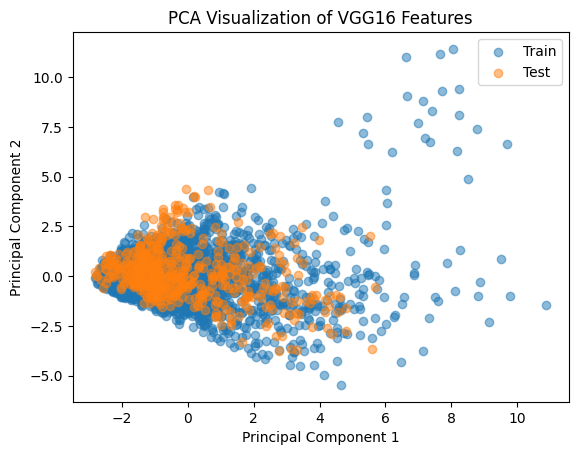

In [22]:
train_features = np.load(vgg16_train_path)
test_features = np.load(vgg16_test_path)

train_features_2d = train_features.reshape(train_features.shape[0], -1)
test_features_2d = test_features.reshape(test_features.shape[0], -1)

all_features_2d = np.concatenate([train_features_2d, test_features_2d])

pca = PCA(n_components=50)
pca_result = pca.fit_transform(all_features_2d)

pca_train = pca_result[:len(train_features)]
pca_test = pca_result[len(train_features):]

plt.scatter(pca_train[:, 0], pca_train[:, 1], label='Train', alpha=0.5)
plt.scatter(pca_test[:, 0], pca_test[:, 1], label='Test', alpha=0.5)
plt.title('PCA Visualization of VGG16 Features')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.show()

In [24]:
variance_rate = pca.explained_variance_ratio_
print(variance_rate)

total = 0
for rate in variance_rate:
    total += rate
print(total)

[0.24207367 0.1338048  0.08052396 0.05553617 0.04839336 0.03347985
 0.02616964 0.02497506 0.0237112  0.01995632 0.01727463 0.01601216
 0.01482435 0.01293615 0.0126255  0.01043779 0.01010014 0.00970957
 0.00910598 0.0085765  0.00728679 0.00709648 0.00648517 0.00617188
 0.00589024 0.00538126 0.00498682 0.00463263 0.00439712 0.00429948
 0.00421413 0.00389238 0.00362736 0.0035012  0.0033407  0.00320514
 0.00306582 0.00293213 0.00287782 0.00280007 0.00266601 0.00252528
 0.00244155 0.00239147 0.00235189 0.00222337 0.00220204 0.00210688
 0.00191166 0.00185813]
0.9229896884644404
